In [23]:
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, GRU, Dropout, Embedding, BatchNormalization, Conv1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 엑셀 파일에서 데이터 불러오기
df = pd.read_excel("/content/drive/MyDrive/Colab/data.xlsx", engine="openpyxl")
print(df.head())
print(df.values.shape)

# 관측소 번호, 관측소명, 일시 등 필요 없는 데이터 열 삭제
df = df.drop(['지점', '지점명', '일시'], axis = 1)
print(df.head())
print(df.values.shape)

In [4]:
shift_hours = 24
target = ['O3']
# 24시간 뒤를 관측할 것이므로 shift_hours = 24 만큼 shift
df_target = df[target].shift(-shift_hours)

print(df[target].head(shift_hours + 5))
df_target.head(5)

       O3
0   0.010
1   0.011
2   0.008
3   0.003
4   0.003
5   0.002
6   0.002
7   0.002
8   0.003
9   0.008
10  0.012
11  0.022
12  0.024
13  0.030
14  0.032
15  0.031
16  0.032
17  0.030
18  0.027
19  0.025
20  0.025
21  0.022
22  0.017
23  0.023
24  0.022
25  0.019
26  0.011
27  0.004
28  0.002


,O3
0,0.022
1,0.019
2,0.011
3,0.004
4,0.002


In [5]:
# shift_hours 만큼 끝의 데이터 잘라내기
x_data = df.values[0:-shift_hours]
print(type(x_data))
print("Shape:", x_data.shape)

y_data = df_target.values[0:-shift_hours]
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (18749, 7)
<class 'numpy.ndarray'>
Shape: (18749, 1)


In [6]:
# 학습 데이터와 테스트 데이터의 비율 설정
num_data = len(x_data)
print("num of data:", num_data)
train_ratio = 0.75
num_train = int(train_ratio * num_data)
num_test = num_data - num_train

num of data: 18749


In [19]:
# 데이터를 학습 데이터와 테스트 데이터로 분리
x_train = x_data[0:num_train]
x_test = x_data[num_train:]

y_train = y_data[0:num_train]
y_test = y_data[num_train:]

num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]


In [20]:
# 다양한 단위의 데이터가 있으므로 MinMax 스케일러로 데이터가 0~1 사이의 값을 갖도록 스케일링
x_scaler = MinMaxScaler()

print("Min Before scaling:", np.min(x_train))
print("Max Before scaling:", np.max(x_train))

x_scaled_train = x_scaler.fit_transform(x_train)
x_scaled_test = x_scaler.transform(x_test)

print("Min After scaling:", np.min(x_scaled_train))
print("Max After scaling:", np.max(x_scaled_train))

y_scaler = MinMaxScaler()
y_scaled_train = y_scaler.fit_transform(y_train)
y_scaled_test = y_scaler.transform(y_test)


Min Before scaling: -11.2
Max Before scaling: 273.0
Min After scaling: 0.0
Max After scaling: 1.0


In [21]:
# 검증(테스트) 데이터 설정
validation_data = (np.expand_dims(x_scaled_test, axis=0),np.expand_dims(y_scaled_test, axis=0))

# 모델 인풋 데이터 설정
x_final = np.expand_dims(x_scaled_train, axis=0)
y_final = np.expand_dims(y_scaled_train, axis=0)

In [17]:
# 모델 구성
model = Sequential()

model.add(GRU(units = 256, return_sequences=True, input_shape=(None, num_x_signals,)))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(num_y_signals, activation='relu'))

model.summary()

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks = [callback_early_stopping]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 256)         203520    
_________________________________________________________________
dense_3 (Dense)              (None, None, 128)         32896     
_________________________________________________________________
dense_4 (Dense)              (None, None, 64)          8256      
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           65        
Total params: 244,737
Trainable params: 244,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 컴파일
model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics = ['acc'], optimizer='Adam')

In [ ]:
# 학습
%%time
history = model.fit(x_final,
          y_final,
          batch_size = 256,
          epochs = 20,
          verbose = 3,
          validation_data = validation_data,
          callbacks = callbacks)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 00010: early stopping
CPU times: user 3min 59s, sys: 12.9 s, total: 4min 12s
Wall time: 2min 17s


In [ ]:
model.save('predict.h5')

In [24]:
# 이전 모델 불러오기
load_model = load_model('/content/drive/MyDrive/Colab/my_model.h5')

result = load_model.evaluate(x=np.expand_dims(x_scaled_test, axis=0), y=np.expand_dims(y_scaled_test, axis=0))

print("loss (test-set):", result)

1/1 [==============================] - 1s 774ms/step - loss: 0.0056 - acc: 0.0094
loss (test-set): [0.005604968406260014, 0.009385665878653526]


In [12]:
result = model.evaluate(x=np.expand_dims(x_scaled_test, axis=0),
                        y=np.expand_dims(y_scaled_test, axis=0))

print("loss (test-set):", result)

RuntimeError: ignored

In [25]:
# 그래프 그리기
def plot_comparison(start_idx, length, train=True):
    if train:
        # 학습 데이터 사용
        x = x_scaled_train
        y_true = y_train
    else:
        # 테스트 데이터 사용
        x = x_scaled_test
        y_true = y_test


    end_idx = start_idx + length
    x = x[start_idx:end_idx]
    x = np.expand_dims(x, axis = 0)
    y_true = y_true[start_idx:end_idx]

    y_pred = load_model.predict(x)
    y_pred_rescale = y_scaler.inverse_transform(y_pred[0])

    signal_pred = y_pred_rescale[:, 0]
    signal_true = y_true[:, 0]

    plt.figure(figsize=(21,7))
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')

    plt.ylabel('O3')
    plt.legend()
    plt.show()


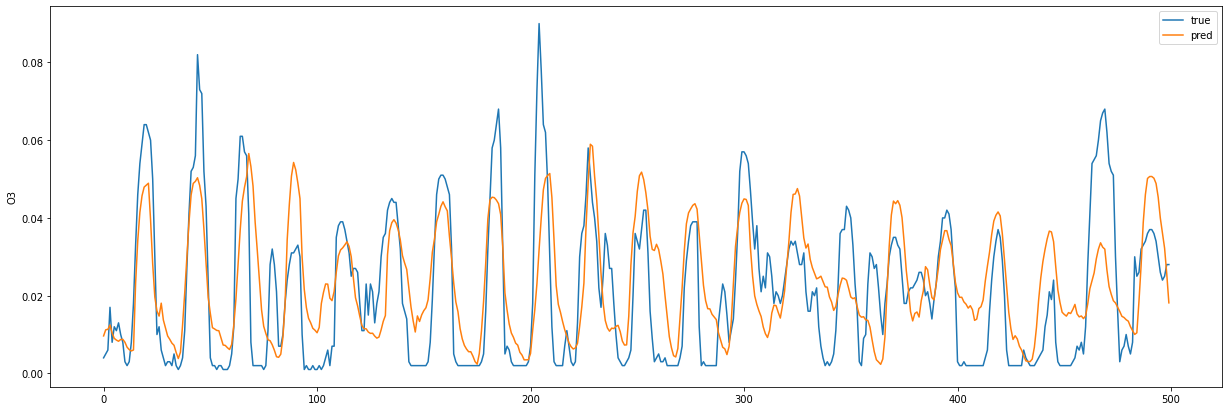

In [27]:
plot_comparison(start_idx = 1000, length = 500, train=False)

In [28]:
# NRMSE 값 구하기
def NRMSE(train=True):
    if train:
        # 학습 데이터 사용
        x = x_scaled_train
        y_true = y_train
    else:
        # 테스트 데이터 사용
        x = x_scaled_test
        y_true = y_test

    x = np.expand_dims(x, axis = 0)
    n = x.shape[1]
    y_pred = load_model.predict(x)
    y_pred_rescale = y_scaler.inverse_transform(y_pred[0])

    RMSE = mean_squared_error(y_true, y_pred_rescale, squared=False)

    print("RMSE: ", RMSE)
    sum = 0;
    for i in range(n):
        sum += y_true[i]
    
    #sum = 실제 관측값 평균
    sum /= n

    return 100 * RMSE / sum

In [29]:
print("NRMSE: {}".format(str(NRMSE(train = False))[1:-1]))

RMSE:  0.015142073392812974
NRMSE: 58.95997414


In [36]:
import requests
import re
from bs4 import BeautifulSoup
import matplotlib as mpl
from datetime import datetime, timedelta

def predict_tomorrow():
    # 기상청 도시별 현재 날씨에서 수원의 기상 정보 받아옴
    wheather_source = requests.get('https://www.weather.go.kr/weather/observation/currentweather.jsp')
    soup = BeautifulSoup(wheather_source.content,"html.parser")

    table = soup.find('table',{'class':'table_develop3'})
    current_data = np.zeros([1,7])
    flag = False
    for tr in table.find_all('tr'):
        tds = list(tr.find_all('td'))
        for td in tds:
            if td.find('a'):
                point = td.find('a').text
                if (point == '수원'):
                    current_data[0][0] = float(tds[5].text)                                             #현재 기온(°C)
                    current_data[0][1] = float(re.findall("\d+\.\d+",tds[11].text.split('(')[1])[0])    #현재 풍속(m/s)
                    current_data[0][2] = float(tds[9].text)                                             #현재 습도(%)
                    flag = True
                    break
        if (flag):
            break

    # 공공데이터 포털의 한국환경공단_에어코리아_대기오염정보 api로 천천동 측정소의 대기 정보 받아옴
    M = '&returnType=xml&numOfRows=100&pageNo=1&stationName=%EC%B2%9C%EC%B2%9C%EB%8F%99&dataTerm=DAILY&ver=1.0'
    key = '0hZJZN2tb1cGI14XLG3tR7dATtivSKg9lF7f%2B58EEHvVnDGqxmxj5aXtarWm%2BNfKEPBxTMWKkduaYZLvdEBQOQ%3D%3D'
    url = 'http://apis.data.go.kr/B552584/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty?serviceKey=' + key + M

    response = requests.get(url)
    soup2 = BeautifulSoup(response.content, "html.parser")

    cv = soup2.find('item')

    pm10 = soup2.find('pm10value').text
    pm25 = soup2.find('pm25value').text
    o3 = soup2.find('o3value').text
    no2 = soup2.find('no2value').text

    try:
        current_data[0][3] = float(pm10)    #현재 PM10(㎍/㎥)
        current_data[0][4] = float(pm25)    #현재 PM2.5(㎍/㎥)
        current_data[0][5] = float(o3)      #현재 오존농도(ppm)
        current_data[0][6] = float(no2)     #현재 이산화질소농도(ppm)
    except ValueError:
        print("현재 측정 값이 없습니다")
        return


    #print(current_data)

    # 현재 시간 + 24시간 뒤의 오존 농도 예측
    now = datetime.now()
    tomorrow = now + timedelta(days = 1) + timedelta(hours = 9)

    x_scaled_current = x_scaler.transform(current_data)
    c = np.expand_dims(x_scaled_current, axis = 0)
    tomorrow_pred = load_model.predict(c)

    tomorrow_pred_rescale = y_scaler.inverse_transform(tomorrow_pred[0])
    O3_pred = float(str(tomorrow_pred_rescale[0])[2:-2])
    O3_pred = round(O3_pred, 3)
    year = tomorrow.year
    month = tomorrow.month
    day = tomorrow.day
    hour = tomorrow.hour

    print("수원시 장안구 천천동의 {0}년 {1}월 {2}일 {3}시 예상 오존 농도는 {4} ppm 입니다.".format(year,month,day,hour,O3_pred))

In [37]:
predict_tomorrow()

현재 측정 값이 없습니다
